### For filtering, spike detection and sorting to obtain single unit activity (discard MUAs)

In [2]:
import pandas as pd
import os
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#### Filtering

In [3]:
data = pd.read_csv('/Users/jazlynn/Downloads/neuron_001.csv')

In [7]:
data

,Time,Voltage
0,0.00000,0.100098
1,0.00008,0.263672
2,0.00016,0.288086
3,0.00024,0.166016
4,0.00032,0.029297
...,...,...
122033,9.76264,0.129395
122034,9.76272,0.070801
122035,9.76280,0.012207
122036,9.76288,0.004883


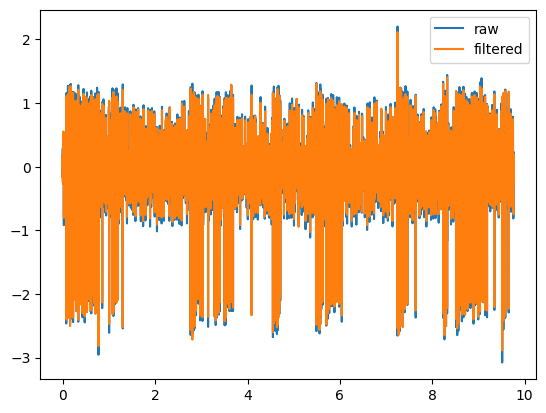

In [18]:
# change no need wrapper... use filtfilt

# Apply a bandpass filter to isolate the frequency range of interest
lowcut = 300  # Low cutoff frequency in Hz
highcut = 6000  # High cutoff frequency in Hz
fs = 12500  # Sampling frequency in Hz

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

filtered_data = butter_bandpass_filter(data['Voltage'], lowcut, highcut, fs)
plt.plot(data['Time'], data['Voltage'], label='raw')
plt.plot(data['Time'],filtered_data, label='filtered')
plt.legend()
# plt.xlim(2.85,2.854) # one AP

#### find peaks

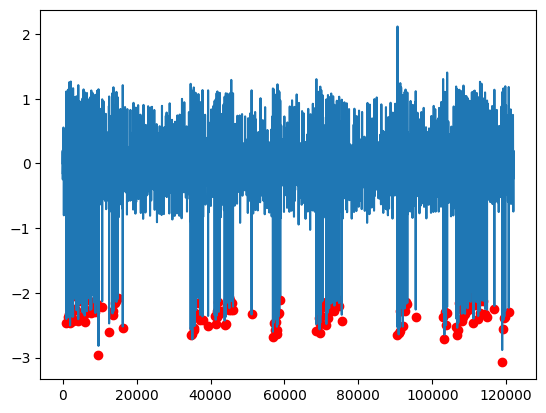

In [25]:
# Find peaks in the filtered data above a certain threshold
threshold = 3.0  # Adjust this threshold as needed
spike_peaks, _ = find_peaks(-filtered_data, height=1.5)
plt.plot([i for i in range(len(data))],filtered_data, label='filtered')
plt.scatter(spike_peaks,data['Voltage'].iloc[spike_peaks], label = 'spikes', color='red')

#### waveforms and clustering

In [29]:
window_size = 50  # Adjust as needed
spike_waveforms = []
for peak in spike_peaks:
    if peak - window_size >= 0 and peak + window_size < len(filtered_data):
        spike_waveforms.append(filtered_data[peak - window_size: peak + window_size])
spike_waveforms = np.array(spike_waveforms)

# Apply PCA for dimensionality reduction
n_components = 3  # Adjust as needed
pca = PCA(n_components=n_components)
waveform_features = pca.fit_transform(spike_waveforms)

# Cluster the waveforms using K-means
n_clusters = 4  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(waveform_features)

/Users/jazlynn/opt/anaconda3/envs/NP/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Viz

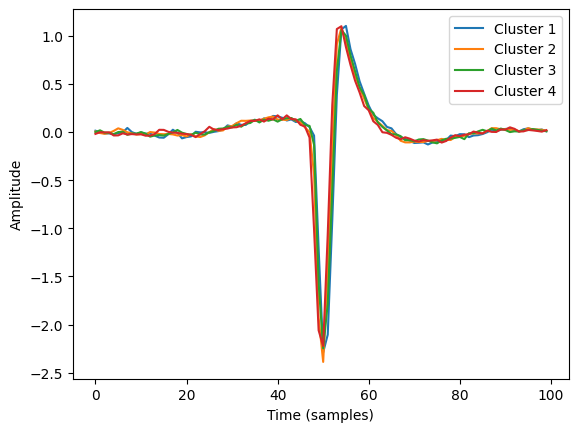

In [31]:
# Visualize the clustered waveforms
for i in range(n_clusters):
    cluster_waveforms = spike_waveforms[cluster_labels == i]
    mean_waveform = np.mean(cluster_waveforms, axis=0)
    plt.plot(mean_waveform, label=f'Cluster {i + 1}')

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()